# 基于昇思MindSpore+Orangepi AIpro的Pix2Pix实现图像转换

功能：使用基于昇思MindSpore框架开发的Pix2Pix实现图像转换。  
样例输入：mindrecord格式的文件。  
样例输出：风格转换后的图象。  

# 前期准备

* 基础镜像的样例目录中已包含转换后的om模型以及测试图片，如果直接运行，可跳过此步骤。如果需要重新转换模型，可以参考下面的步骤。
* **建议在Linux服务器或者虚拟机转换该模型。**
* 为了能进一步优化模型推理性能，我们需要将其转换为om模型进行使用；**转换指导详见全流程实验指导。**

# 模型推理实现

* 注意：本案例在离线推理的过程中可能会出现内存不足的问题，可以根据情况查看FAQ文档中的解决方案。

### 1. 导入三方库

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import acl

import acllite_utils as utils
import constants as const
from acllite_model import AclLiteModel
from acllite_resource import resource_list

import mindspore as ms
import mindspore.dataset as ds

from mindspore.dataset import vision

### 2. 定义acllite资源初始化与去初始化类

In [2]:
class AclLiteResource:
    """
    AclLiteResource
    """
    def __init__(self, device_id=0):
        self.device_id = device_id
        self.context = None
        self.stream = None
        self.run_mode = None
        
    def init(self):
        """
        init resource
        """
        print("init resource stage:")
        ret = acl.init()

        ret = acl.rt.set_device(self.device_id)
        utils.check_ret("acl.rt.set_device", ret)

        self.context, ret = acl.rt.create_context(self.device_id)
        utils.check_ret("acl.rt.create_context", ret)

        self.stream, ret = acl.rt.create_stream()
        utils.check_ret("acl.rt.create_stream", ret)

        self.run_mode, ret = acl.rt.get_run_mode()
        utils.check_ret("acl.rt.get_run_mode", ret)

        print("Init resource success")

    def __del__(self):
        print("acl resource release all resource")
        resource_list.destroy()
        if self.stream:
            print("acl resource release stream")
            acl.rt.destroy_stream(self.stream)

        if self.context:
            print("acl resource release context")
            acl.rt.destroy_context(self.context)

        print("Reset acl device ", self.device_id)
        acl.rt.reset_device(self.device_id)
        print("Release acl resource success")

### 3. 定义图像转换类，包含前处理、推理、结果展示等操作

In [3]:
class Conversion(object):
    """
    class for Conversion
    """
    def __init__(self, model_path):
        self._model_path = model_path
        self.device_id = 0
        self._model = None

    def init(self):
        """
        Initialize
        """
        # Load model
        self._model = AclLiteModel(self._model_path)

        return const.SUCCESS

    def pre_process(self, input_path):
        
        dataset = ds.MindDataset(input_path, columns_list=["input_images", "target_images"], shuffle=True)
        data_iter = next(dataset.create_dict_iterator(output_numpy=True))
        result1 = ms.Tensor(data_iter["input_images"])

        return result1, data_iter
    
    def inference(self, result1):
        """
        model inference
        """
        predict_show_list  = self._model.execute([result1.asnumpy(), ])
        predict_show = np.array(predict_show_list)
        
        return predict_show      

    def show_process(self, predict_show, data_iter):
        """
        show process
        """
        plt.figure(figsize=(10, 3), dpi=140)
        for i in range(10):
            plt.subplot(2, 10, i + 1)
            plt.imshow(((data_iter["input_images"][i]).transpose(1, 2, 0) + 1) / 2)
            plt.axis("off")
            plt.subplots_adjust(wspace=0.05, hspace=0.02)
            plt.subplot(2, 10, i + 11)
            plt.imshow((predict_show[0][i].transpose(1, 2, 0) + 1) / 2)
            plt.axis("off")
            plt.subplots_adjust(wspace=0.05, hspace=0.02)
        plt.show()
    

### 4. 构造主函数，串联整个代码逻辑

In [ ]:
from download import download
# 获取数据集
dataset_url = "https://modelers.cn/coderepo/web/v1/file/MindSpore-Lab/cluoud_obs/main/media/examples/mindspore-courses/orange-pi-mindspore/08-Pix2pix/dataset.zip"
download(dataset_url, "./", kind="zip", replace=True)
# 获取模型om文件
model_url = "https://modelers.cn/coderepo/web/v1/file/MindSpore-Lab/cluoud_obs/main/media/examples/mindspore-courses/orange-pi-mindspore/08-Pix2pix/pix2pix.zip"
download(model_url, "./", kind="zip", replace=True)

In [4]:
def main():
    MODEL_PATH = "pix2pix.om"
    input_path = "./dataset/pix2pix_data.mindrecord"

    acl_resource = AclLiteResource()  # 初始化acl资源
    acl_resource.init()
    
    # instantiation Conversion object
    conversion = Conversion(MODEL_PATH)  # 构造模型对象
    
    # init
    ret = conversion .init()  # 初始化模型类变量
    utils.check_ret("conversion.init ", ret)  

    # read image
    image_pre, data_iter = conversion.pre_process(input_path)  # 数据读取
    
    # inference
    predict_show = conversion.inference(image_pre)  # 推理

    # show
    conversion.show_process(predict_show , data_iter)  # 结果展示
    


### 5. 运行
运行完成后，会显示推理后的图片，如下所示。

init resource stage:
Init resource success
Init model resource start...
[AclLiteModel] create model output dataset:
malloc output 0, size 12582912
Create model output dataset success
Init model resource success


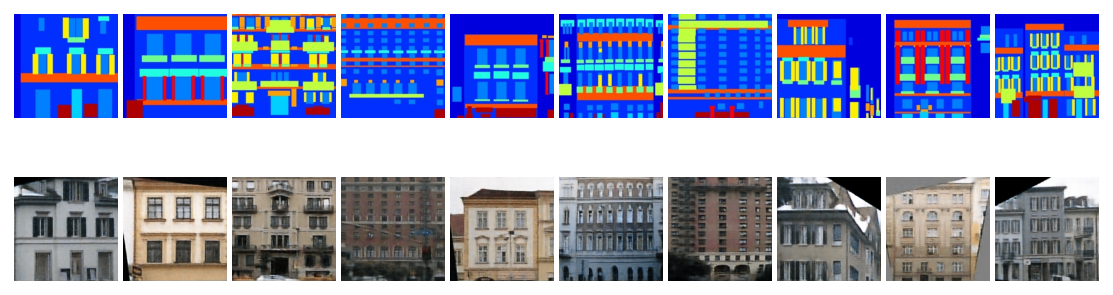

acl resource release all resource
AclLiteModel release source success
acl resource release stream
acl resource release context
Reset acl device  0
Release acl resource success


In [5]:
main()

# 样例总结

我们来回顾一下以上代码，可以包括以下几个步骤：

1. 初始化acl资源：在调用acl相关资源时，必须先初始化AscendCL，否则可能会导致后续系统内部资源初始化出错。  
2. 对图片进行前处理：在此样例中，我们首先根据图片路径，使用mindspore.dataset.MindDataset接口下加载测试用数据集。然后基于数据集对象使用mindspore中的create_dict_iterator接口创建数据迭代器。
3. 推理：利用AclLiteModel.execute接口对数据进行推理。  
5. 可视化图片：利用plt将结果画出。